## Analyzing data from  [CROL, NY](https://a856-cityrecord.nyc.gov/Home/AboutUs) 

In [455]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import datetime as dt
from bs4 import BeautifulSoup
import requests


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)

#add data path
data_path='../data/'

### Useful functions

In [509]:
def fetch_data(path,fname='Recent_Contract_Awards.csv'):
    df=pd.read_csv(data_path+fname)
    return df

def get_null_columns(df):
    null_columns=[]
    for col in df.columns:
        if df[col].isnull().all():
            null_columns.append(col)
    return null_columns

def drop_null_columns(df,null_columns):
    for col in null_columns:
        df.drop(col,axis=1, inplace=True)
    return df

def filter_df(df):
    filter_df_1=df[(cleaned_df['StartDate'].dt.year >= 2010) & (df['StartDate'].dt.year <= 2019)]
    filter_df_2=filter_df_1[filter_df_1['ContractAmount'].notna()][filter_df_1[filter_df_1['ContractAmount'].notna()]['ContractAmount'] >0]
    return filter_df_2
    
def get_NYC_zip():
    weblink='https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm'
    page=requests.get(weblink)
    zip_page= BeautifulSoup(page.content, 'html.parser')
    Table=[item.get_text().replace(' ','').replace('-','').replace('.','') for item in zip_page.findAll("td")]
    NY_zip=[]
    for i,j in enumerate(Table):
        if j.isalpha()==False:
            pins=j.split(',')
            for pin in pins:
                NY_zip.append(pin)
    return NY_zip

#### Keep only rows with a StartDate occurring from 2010 to 2019, inclusive. Next, remove all rows for which the ContractAmount field is less than or equal to zero, or is missing entirely. Use this filtered data for the rest of the challenge, as well. For the remaining data, what is the total sum of contract amounts?

In [56]:
#df=fetch_data()
cleaned_df=drop_null_columns(df,get_null_columns(df))
#cleaned_df['StartDate'].dtype
cleaned_df['StartDate']= pd.to_datetime(df['StartDate']) 
cleaned_df['EndDate']= pd.to_datetime(df['EndDate']) 
#cleaned_df['StartDate'].dtype
filtered_df=filter_df(cleaned_df)


In [141]:
answer_quest_1=filtered_df['ContractAmount'].sum(axis=0)
print ("Total sum of contract amounts is: %f"%answer_quest_1)

Total sum of contract amounts is: 207783994327.839996


#### Determine the number of contracts awarded by each agency. For the top 5 agencies in terms the number of contracts, compute the mean ContractAmount per contract. Among these values, what is the ratio of the highest mean contract amount to the second highest?

In [109]:
Top_five_agencies_df=filtered_df.groupby(['AgencyName']).count().sort_values('RequestID',ascending=False)
Top_five=Top_five_agencies_df.reset_index().iloc[0:5,:]['AgencyName'].to_list()
Mean_contract_amount=filtered_df.groupby(['AgencyName']).mean().reset_index()
Top_five_contact_amount=[]
for i in Top_five:
    Top_five_contact_amount.append(Mean_contract_amount[Mean_contract_amount['AgencyName']==i]['ContractAmount'].values[0])
T5_sorted=sorted(Top_five_contact_amount)
Ratio=T5_sorted[-1]/T5_sorted[-2]
print ("Ratio of the highest mean contract amount to the second highest is %f"%Ratio)


Ratio of the highest mean contract amount to the second highest is 4.792396


#### Consider only procurements made by the Citywide Administrative Services agency and compute the sum contract amount awarded to each unique vendor. What proportion of the total number of contracts in the data set were awarded to the top 50 vendors?

In [128]:
CAS=filtered_df[filtered_df['AgencyName']=='Citywide Administrative Services']
Top50_vendors=CAS.groupby(['VendorName']).sum().sort_values('ContractAmount',ascending=False).iloc[0:50,:].reset_index()['VendorName'].to_list()

In [137]:
all_vendors=CAS.groupby(['VendorName']).count().reset_index()
Total_num_contracts=all_vendors.sum()['RequestID']
print ("Total number of contracts awarded %d"%Total_num_contracts)

Total number of contracts awarded 5098


In [139]:
Contracts_for_top50=all_vendors[all_vendors['VendorName'].isin(Top50_vendors)].sum()['RequestID']
print ("Total number of contracts awarded to top 50 vendors %d"%Contracts_for_top50)

Total number of contracts awarded to top 50 vendors 197


In [140]:
print ("Percentage of contracts to top 50 vendors is %f"%(Contracts_for_top50/Total_num_contracts))

Percentage of contracts to top 50 vendors is 0.038643


#### For this question, consider only contracts with in the categories of Construction Related Services and Construction/Construction Services. The ShortTitle field contains a description of the procured goods/services for each contract. Compute the sum contract amount for contracts whose ShortTitle refer to 'CENTRAL PARK' and for those which refer to 'WASHINGTON SQUARE PARK'. What is the ratio of total construction and contruction-related expenditure for the Central Park contracts compared to the Washington Square Park contracts? Note: you should ensure that 'PARK' appears on its own and not as the beginning of another word.

In [196]:
categories=['Construction/Construction Services','Construction Related Services']
categories_df=filtered_df[filtered_df['CategoryDescription'].isin(categories)]
#categories_df[categories_df['ShortTitle'].str.contains(r'(?:\s|^)CENTRAL PARK(?:\s|$)')]['ShortTitle'].unique()
central_park=categories_df[categories_df['ShortTitle'].str.contains(r'(?:\s|^)CENTRAL PARK(?:\s|$)')]
CP_sum=central_park['ContractAmount'].sum()
print ("Sum amount for Central park contracts is %f"%(CP_sum))
Wash_park=categories_df[categories_df['ShortTitle'].str.contains('WASHINGTON SQUARE PARK')]
WP_sum=Wash_park['ContractAmount'].sum()
print ("Sum amount for Washington square park contracts is %f"%(WP_sum))
print ("The ratio between Central park and Washington square park is %f"%(CP_sum/WP_sum))


Sum amount for Central park contracts is 13064125.600000
Sum amount for Washington square park contracts is 8939669.240000
The ratio between Central park and Washington square park is 1.461366


#### Consider only contracts awarded by the Citywide Administrative Services agency in the category Goods. Compute the total yearly expenditure (using StartDate) for these contracts and fit a linear regression model to these values. What is the R^2 value for this model?

In [201]:
CAS_df=filtered_df[(filtered_df['AgencyName']=='Citywide Administrative Services') & \
                  (filtered_df['CategoryDescription']=='Goods')]
CAS_df

,RequestID,StartDate,EndDate,AgencyName,TypeOfNoticeDescription,CategoryDescription,ShortTitle,SelectionMethodDescription,SectionName,SpecialCaseReasonDescription,...,ContactPhone,Email,ContractAmount,AdditionalDescription1,OtherInfo1,VendorName,VendorAddress,Printout1,Printout2,DocumentLinks
206,20151019009,2015-10-26,2015-10-26,Citywide Administrative Services,Award,Goods,"EQUIPMENT II, RENTAL OF VARIOUS",Other,Procurement,NaN,...,NaN,NaN,219456.00,NaN,Original Vendor: United Rentals (North Americ...,Hertz Equipment Rental Corp,"206 Route 109 East, Farmingdale, NY 11735","EQUIPMENT II, RENTAL OF VARIOUS - Other - PIN#...",NaN,NaN
207,20190531014,2019-06-07,2019-06-07,Citywide Administrative Services,Award,Goods,NYS OGS - TASK FORCE RESCUE SYSTEM - FDNY,Intergovernmental Purchase,Procurement,Other (Describe below in Other Legally Mandate...,...,NaN,NaN,424851.80,NaN,OGS Contr PC66825 Suppliers wishing to be cons...,Zistos Corporation,"1736 Church Street, Holbrook, NY 11741",NYS OGS - TASK FORCE RESCUE SYSTEM - FDNY - In...,NaN,NaN
209,20160420023,2016-04-27,2016-04-27,Citywide Administrative Services,Award,Goods,SNACKS,Competitive Sealed Bids,Procurement,NaN,...,NaN,NaN,6138.00,NaN,NaN,Keefe Group LLC,"301 Mill Road, Edison, NJ 08837",SNACKS - Competitive Sealed Bids - PIN# 857160...,NaN,NaN
224,20160425024,2016-05-02,2016-05-02,Citywide Administrative Services,Award,Goods,"FRUITS AND VEGETABLES - FRESH, SEASONAL",Competitive Sealed Bids,Procurement,NaN,...,NaN,NaN,1327263.96,NaN,NaN,Plainfield Fruit and Produce Company Inc,"82 Executive Avenue, Edison, NJ 08817","FRUITS AND VEGETABLES - FRESH, SEASONAL - Co...",NaN,NaN
238,20130730008,2013-08-06,2013-08-06,Citywide Administrative Services,Award,Goods,OTI MICROPLATE DRUGS OF ABUSE AND TEST KITS,Competitive Sealed Bids,Procurement,NaN,...,NaN,NaN,331512.00,NaN,NaN,ORASURE TECHNOLOGIES INC.,"220 EAST FIRST STREET, BETHLEHEM, PA 18015",OTI MICROPLATE DRUGS OF ABUSE AND TEST KITS - ...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35534,20111227014,2012-01-04,2012-01-04,Citywide Administrative Services,Award,Goods,"WATER METERS, LARGE (D.E.P.)",Competitive Sealed Bids,Procurement,NaN,...,NaN,NaN,370890.00,NaN,NaN,Neptune Technology Group Inc,"1600 Alabama Highway 229, Tallassee, AL 36078","WATER METERS, LARGE (D.E.P.) - Competitive Sea...",NaN,NaN
35536,20140819030,2014-08-26,2014-08-26,Citywide Administrative Services,Award,Goods,"GROCERIES, MISCELLANEOUS, HRA EFNAP",Competitive Sealed Bids,Procurement,NaN,...,NaN,NaN,166938.80,NaN,NaN,"H Schrier And Company, Inc.","4901 Glenwood Road, Brooklyn, NY 11234","GROCERIES, MISCELLANEOUS, HRA EFNAP - Competit...",NaN,NaN
35540,20101202005,2010-12-09,2010-12-09,Citywide Administrative Services,Award,Goods,CERVICAL EXTRICATION COLLARS (ADJUSTABLE/FDNY),Competitive Sealed Bids,Procurement,NaN,...,NaN,NaN,242416.80,NaN,NaN,Ambu Inc.,"6740 Baymeadow Drive, Glen Burnie, MD 21060",CERVICAL EXTRICATION COLLARS (ADJUSTABLE/FDNY)...,NaN,NaN
35541,20131218023,2013-12-27,2013-12-27,Citywide Administrative Services,Award,Goods,TOTAL SOLUTIONS FOR LAW ENFORCEMENT/SECURITY I...,Intergovernmental Purchase,Procurement,Other (Describe below in Other Legally Mandate...,...,NaN,NaN,332469.81,NaN,GSA Contract #GS-07F-0362T Supliers wishing t...,GRAVOIS ALUMINUM BOATS LLC METAL SHARK ALUMINU...,"6814- E ADMIRAL DOYLE DRIVE , JEANERETTE LA 7...",TOTAL SOLUTIONS FOR LAW ENFORCEMENT/SECURITY I...,NaN,NaN


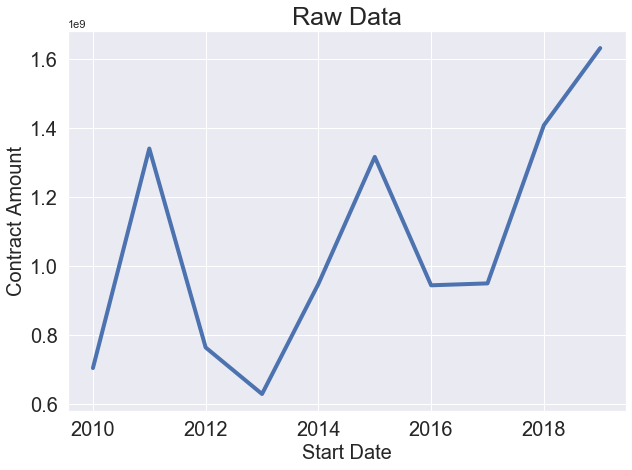

In [234]:
CAS_LR=CAS_df.groupby(CAS_df['StartDate'].dt.year).sum().reset_index()
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax = sns.lineplot(x="StartDate", y="ContractAmount", data=CAS_LR,linewidth=4)
ax.set_title("Raw Data",fontsize=25);
ax.set_xlabel("Start Date",fontsize=20);
ax.set_ylabel("Contract Amount",fontsize=20);
ax.tick_params(labelsize=20);

Intercept of the fit: -134075962409.681381
Coefficient of fit: 67083454.963636
R squared of fit: 0.359876


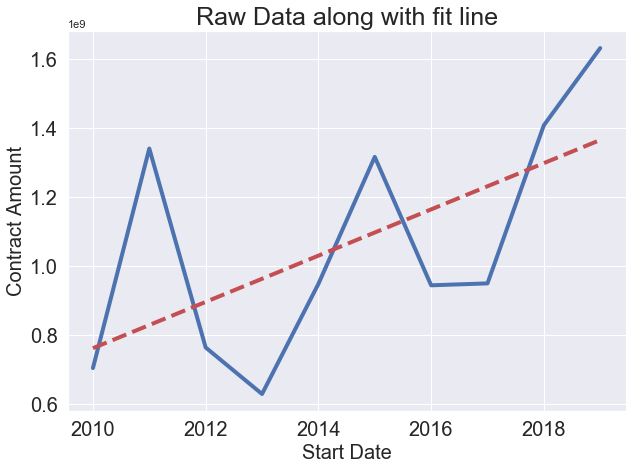

In [272]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = CAS_LR['StartDate'].values.reshape(-1,1)
y = CAS_LR['ContractAmount'].values.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X, y)
print("Intercept of the fit: %f"%regressor.intercept_)
print("Coefficient of fit: %f"%regressor.coef_)
print("R squared of fit: %f"%regressor.score(X, y))
fit_line=regressor.coef_*CAS_LR['StartDate'].values +regressor.intercept_
CAS_LR['Fit_line']=fit_line.reshape(10,1)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax = sns.lineplot(x="StartDate", y="ContractAmount", data=CAS_LR,linewidth=4)
ax = sns.lineplot(x="StartDate", y="Fit_line", data=CAS_LR,linewidth=4,color='r')
ax.lines[1].set_linestyle("--")
ax.set_title("Raw Data along with fit line",fontsize=25);
ax.set_xlabel("Start Date",fontsize=20);
ax.set_ylabel("Contract Amount",fontsize=20);
ax.tick_params(labelsize=20);

#### Do agencies publish procurement notices uniformly throughout the week? As an example, consider the agency of Parks and Recreation. For this agency, compute the weekday for which each notice was published, and perform a Chi-squared test on the null hypothesis that each weekday occurs equally often. Report the value of the test statistic.

In [304]:
ParksRec=filtered_df[filtered_df['AgencyName']=='Parks and Recreation']

In [307]:
ParksRec['DayOfDate'] = ParksRec['StartDate'].dt.day_name()
Chi_df=ParksRec.groupby(['DayOfDate']).count().reset_index()[['DayOfDate','RequestID']]
Chi_df['ExpectedID']=[709/5]*5

def chi(row):
    chi=((row['RequestID']-row['ExpectedID'])**2)/row['ExpectedID']
    return chi

Chi_df['ChiSqValue'] = Chi_df.apply(chi, axis=1)
Chi_df['ChiSqValue'].sum()

print("Chi squared value for fit: %f"%Chi_df['ChiSqValue'].sum())
print("Degree of freedom is 4 (n-1), and critical value at 4 is 9.488, since the value is less than that,we will accept the null hypothesis")


8.623413258110013

Chi squared value for fit: 8.623413
Degree of freedom is 4, and critical value at 4 is 9.488, since the value is less than that,we will accept the null hypothesis


#### Is there a predictable, yearly pattern of spending for certain agencies? As an example, consider the Environmental Protection agency. For each month from 2010 through the end of 2019, compute the monthly expenditure for each agency. Once again, use StartDate for the contract date. Then, with a lag of 12 months, report the autocorrelation for total monthly expenditure.

In [343]:
EPA=filtered_df[filtered_df['AgencyName']=='Environmental Protection']
EPA_monthly=EPA.groupby(pd.Grouper(key='StartDate', freq='M')).sum().reset_index()
EPA_monthly

,StartDate,RequestID,ContractAmount
0,2010-02-28,40200250041,1.165714e+07
1,2010-03-31,100501583091,2.345447e+07
2,2010-04-30,60301239015,6.084658e+06
3,2010-05-31,40201040022,1.491812e+06
4,2010-06-30,60301854043,2.454927e+06
...,...,...,...
114,2019-08-31,686487268469,2.909235e+09
115,2019-09-30,201909043123,1.542845e+07
116,2019-10-31,282673831180,2.152839e+07
117,2019-11-30,121146576139,5.725265e+07


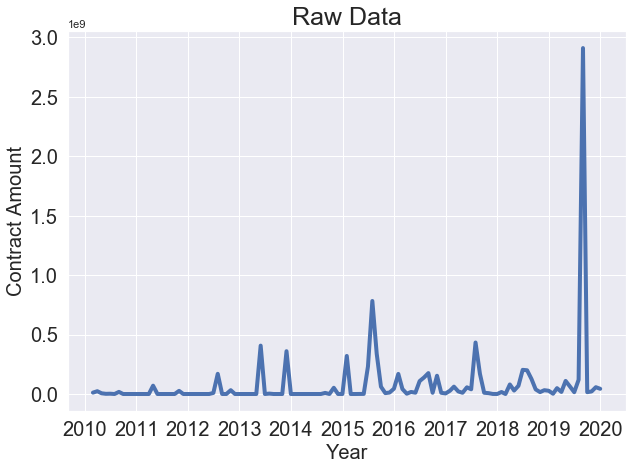

In [344]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax = sns.lineplot(x="StartDate", y="ContractAmount", data=EPA_monthly,linewidth=4)
ax.set_title("Raw Data",fontsize=25);
ax.set_xlabel("Start Date",fontsize=20);
ax.set_ylabel("Contract Amount",fontsize=20);
ax.tick_params(labelsize=20);
plt.xlabel('Year', fontsize=20);

Text(0.5, 1.0, 'Autocorrelation')

Text(0.5, 0, 'Lag')

Text(0, 0.5, 'Autocorrelation')

(0, 25)

(-0.25, 0.25)

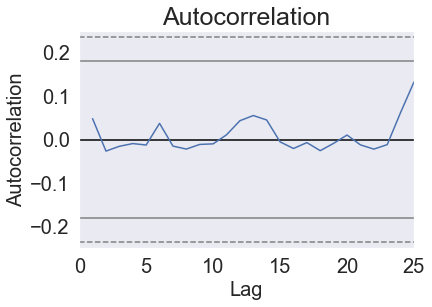

In [405]:
ax=pd.plotting.autocorrelation_plot(EPA_monthly['ContractAmount']);
#ax.set_ylim([0,0.045])
ax.set_title("Autocorrelation",fontsize=25);
ax.set_xlabel("Lag",fontsize=20);
ax.set_ylabel("Autocorrelation",fontsize=20);
ax.tick_params(labelsize=20);
ax.set_xlim([0,25])
ax.set_ylim([-0.25,0.25])

#EPA_monthly['ContractAmount'].autocorr(lag=12)

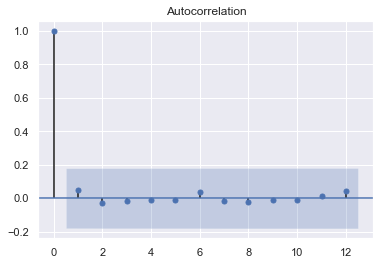

In [400]:
from statsmodels.graphics import tsaplots
ax1= fig.add_subplot(111)
fig= tsaplots.plot_acf(EPA_monthly['ContractAmount'],lags=12)

### In this question, we will examine whether contract expenditure goes to companies located within or outside of New York City. To do so, we will extract the ZIP codes from the VendorAddress field. The ZIP codes pertaining to New York City can be found at the following URL: https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm. Looking only at contracts with a StartDate in 2018, compute the total expenditure for contracts awarded to vendors listing NYC addresses and those located elsewhere. Report the proportion of the total expenditures awarded to the NYC vendors.

In [522]:
Zip_2018=filtered_df[filtered_df['StartDate'].dt.year==2018]

def get_zip(address):
    address=address.replace(',',' ').replace('(M/WBE)','').replace('(MWBE)','').replace('(mwbe)','').replace('.','').replace('m/wbe)','')
    zip_chunk=address.split()[-1]
    if ('-' in zip_chunk) and len(zip_chunk.split('-')[0])==5 and zip_chunk.split('-')[0].isdigit():
        zip=zip_chunk.split('-')[0]
    elif len(zip_chunk)==9 and zip_chunk.isdigit():
        zip=zip_chunk[0:5]
    elif zip_chunk.isalpha():
        zip='None'
    elif len(zip_chunk)<5:
        zip='None'
    elif zip_chunk.isdigit() and len(zip_chunk)==5:
        zip=zip_chunk
    else:
        zip='None'
    return zip

Zip_2018['Zip code']=Zip_2018.VendorAddress.apply(get_zip)
#Zip_2018['Zip code'].unique()
NY_zip=get_NYC_zip()
Zip_2018_NYC=Zip_2018[Zip_2018['Zip code'].isin(NY_zip)]
NYC=Zip_2018_NYC['ContractAmount'].sum()
Zip_2018_others=Zip_2018[~Zip_2018['Zip code'].isin(NY_zip)]
others=Zip_2018_others['ContractAmount'].sum()
print("Total value of contract amount awarded to vendors in NYC is: %f"%NYC)
print("Total value of contract amount awarded to other vendoes is: %f"%others)
print("Total value of contract amount awarded to vendors in NYC compared to others is: %f"%(NYC/others))



Total value of contract amount awarded to vendors in NYC is: 6324801571.150000
Total value of contract amount awarded to other vendoes is: 12418320198.880001
Total value of contract amount awarded to vendors in NYC compared to others is: 0.509312
